# Quant project

### 数据加载

In [1]:
import baostock as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

baostack文档：http://baostock.com/baostock/index.php/%E9%A6%96%E9%A1%B5   # 只支持python 3.5以上、需要翻墙

In [2]:
# 规模指数，例如：sh.000016 上证50，sh.000300 沪深300，sh.000905 中证500，sz.399001 深证成指等；
ZSNAME = 'sh.000300'
# Baostock 从 2006-01-04
SD = '2006-01-01'
# 导出的文件形式
SAVENAME = ZSNAME+'_'+SD+'.csv'

In [3]:
# #### 更新数据 ####
# #### baostock登陆系统 ####
# lg = bs.login()
# # 显示登陆返回信息
# print('login respond error_code:'+lg.error_code)
# print('login respond  error_msg:'+lg.error_msg)

# #### 获取历史K线数据 ####
# rs = bs.query_history_k_data(ZSNAME,
#     "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
#     start_date= SD,
#     frequency="d", adjustflag="3")
# print('query_history_k_data respond error_code:'+rs.error_code)
# print('query_history_k_data respond  error_msg:'+rs.error_msg)

# #### 打印结果集 ####
# data_list = []
# while (rs.error_code == '0') & rs.next():
#     # 获取一条记录，将记录合并在一起
#     data_list.append(rs.get_row_data())
# KL = pd.DataFrame(data_list, columns=rs.fields)

# #### 登出系统 ####
# bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data respond error_code:0
query_history_k_data respond  error_msg:success
logout success!


In [4]:
# #### 结果可以输出到csv文件 #### 
# KL.to_csv(SAVENAME,index=False)

使用python的baostock接口，实现股票自动盯盘:https://blog.csdn.net/dongdong2980/article/details/80420220

In [5]:
KL = pd.read_csv(SAVENAME)
KL['date'] = pd.to_datetime(KL['date'])
# 看缺省值
KL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 14 columns):
date           3122 non-null datetime64[ns]
code           3122 non-null object
open           3122 non-null float64
high           3122 non-null float64
low            3122 non-null float64
close          3122 non-null float64
preclose       3122 non-null float64
volume         3122 non-null int64
amount         3122 non-null float64
adjustflag     3122 non-null int64
turn           3122 non-null float64
tradestatus    3122 non-null int64
pctChg         3122 non-null float64
isST           2351 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 341.5+ KB


### 数据清洗

Text(0.5,1,'KL')

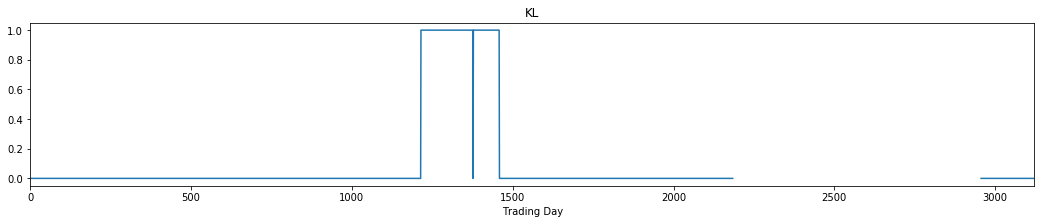

In [6]:
# 查看isST
fig = plt.figure(figsize=(18,3))
for name in ['isST']:
    plt.plot(range(0,KL.shape[0]),KL[name])
plt.xlim(0,KL.shape[0])
plt.xlabel('Trading Day')
plt.title('KL')

In [7]:
# 其实是分类变量 该做变换 但全一致不影响
print(KL.adjustflag.value_counts())
print(KL.tradestatus.value_counts())
# 课删掉
KL.drop('adjustflag', axis=1, inplace=True)  # 复权状态(1：后复权， 2：前复权，3：不复权）
KL.drop('tradestatus', axis=1, inplace=True) # 交易状态(1：正常交易 0：停牌）
# 其他删掉
KL.drop('preclose', axis=1, inplace=True) # 昨日收盘价
KL.drop('pctChg', axis=1, inplace=True)   # 涨跌幅
KL.drop('volume', axis=1, inplace=True)   # 成交量（累计 单位：股）
KL.drop('amount', axis=1, inplace=True)   # 成交额（单位：人民币元）
KL.drop('turn', axis=1, inplace=True)     # 换手率
KL.drop('isST', axis=1, inplace=True)     # 是否ST股，1是，0否

3    3122
Name: adjustflag, dtype: int64
1    3122
Name: tradestatus, dtype: int64


### 数据变换

In [8]:
#计算【移动平均】+【标准差】：5日，10日，20日
for ma in [5,10,20]:
    KL['ma'+str(ma)] = KL['close'].rolling(ma).mean()
    KL['std'+str(ma)] = KL['close'].rolling(ma).std()

for name in ['close','ma5','ma10','ma20','std5','std10','std20']:
    #计算【变化量】：收盘价，和5日，10日，20日，30日，60日的移动平均+标准差
    KL['d'+name] = KL[name].diff()
    #计算【变化率】：收盘价，和5日，10日，20日，30日，60日的移动平均+标准差
    KL['v'+name] = KL['d'+name]/ KL[name].shift(1)
    
# 计算【布林带位置】：5日，10日，20日
for ma in [5,10,20]:  
    KL['pp'+str(ma)] = (KL['close'] - KL['ma'+str(ma)])/ (2 * KL['std'+str(ma)]) 

In [9]:
# 计算【5日均线和 10日均线的差距】
KL['D12'] = (KL['ma5'] - KL['ma10'])
KL['dis12'] = (KL['ma5'] - KL['ma10'])/ KL['ma10']
# 计算【5日均线和 20日均线的差距】
KL['D13'] = (KL['ma5'] - KL['ma20'])
KL['dis13'] = (KL['ma5'] - KL['ma20'])/ KL['ma20']
# 计算【10日均线和 20日均线的差距】
KL['D23'] = (KL['ma10'] - KL['ma20'])
KL['dis23'] = (KL['ma10'] - KL['ma20'])/ KL['ma20']

In [10]:
# std10/close、std20/close
KL['std10close'] = KL['std10'] / KL['close']
KL['std20close'] = KL['std20'] / KL['close']

# Posi 20_open
KL['pp20open'] = (KL['open'] - KL['ma20'])/ (2 * KL['std20']) 

In [11]:
# 考虑还可以生成其他特征?

In [12]:
# 滞后变量 2期  
for col in KL.columns[2:]: # 取[2:]是因为'date','code'不用滞后   
    for i in range(0,2):
        KL[col+'_l'+str(i+1)]=KL[col].shift(i+1)          
print('Done')

Done


### 目标特征

In [13]:
# y:  下一日的 收盘价 涨跌 涨1 跌-1
# y2: 下一日的 收盘价 变化量
KL['y']= KL.dclose.shift(-1)
KL['y2']= KL.dclose.shift(-1)
KL.y[KL.y2==0] = 0
KL.y[KL.y2> 0] = 1
KL.y[KL.y2< 0] = -1

/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
# 最新一日的目标特征未知：删除
KL.drop(KL[KL.date==KL.date.max()].index, axis=0, inplace=True)

In [15]:
# 检查
KL.y.value_counts()

 1.0    1683
-1.0    1438
Name: y, dtype: int64

In [16]:
KL.shape

(3121, 112)

### 取样分组

In [79]:
Tsplit = '2017-01-01'

train_X = KL[KL.date>'2006-12-31'][KL.date< Tsplit]
test_X = KL[KL.date>= Tsplit]

train_y = KL.y[KL.date>'2006-12-31'][KL.date< Tsplit].astype(int)
test_y = KL.y[KL.date>= Tsplit].astype(int)

train_y2 = KL.y2[KL.date>'2006-12-31'][KL.date< Tsplit]
test_y2 = KL.y2[KL.date>= Tsplit]

/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
print(train_y.value_counts())
print(test_y.value_counts())

 1    1292
-1    1140
Name: y, dtype: int64
 1    235
-1    213
Name: y, dtype: int64


### 特征选取

In [81]:
# 单位根检验 ——Augmented Dickey-Fuller test
import statsmodels.tsa.stattools as ts

pickcol=[]
dropcol=[]
for col in train_X.columns[2:]:       
    result = ts.adfuller(train_X[col],0,autolag='AIC')
    if result[1]<=0.01:
        pickcol.append(col)
    else:
        dropcol.append(col)
print(pickcol)
print('------------')
print('We can drop:')
print(dropcol)

['std5', 'std10', 'dclose', 'vclose', 'dma5', 'vma5', 'dma10', 'vma10', 'dma20', 'vma20', 'dstd5', 'vstd5', 'dstd10', 'vstd10', 'dstd20', 'vstd20', 'pp5', 'pp10', 'pp20', 'D12', 'dis12', 'D13', 'dis13', 'D23', 'dis23', 'std10close', 'std20close', 'pp20open', 'std5_l1', 'std5_l2', 'std10_l1', 'std10_l2', 'dclose_l1', 'dclose_l2', 'vclose_l1', 'vclose_l2', 'dma5_l1', 'dma5_l2', 'vma5_l1', 'vma5_l2', 'dma10_l1', 'dma10_l2', 'vma10_l1', 'vma10_l2', 'dma20_l1', 'dma20_l2', 'vma20_l1', 'vma20_l2', 'dstd5_l1', 'dstd5_l2', 'vstd5_l1', 'vstd5_l2', 'dstd10_l1', 'dstd10_l2', 'vstd10_l1', 'vstd10_l2', 'dstd20_l1', 'dstd20_l2', 'vstd20_l1', 'vstd20_l2', 'pp5_l1', 'pp5_l2', 'pp10_l1', 'pp10_l2', 'pp20_l1', 'pp20_l2', 'D12_l1', 'D12_l2', 'dis12_l1', 'dis12_l2', 'D13_l1', 'D13_l2', 'dis13_l1', 'dis13_l2', 'D23_l1', 'D23_l2', 'dis23_l1', 'dis23_l2', 'std10close_l1', 'std10close_l2', 'std20close_l1', 'std20close_l2', 'pp20open_l1', 'pp20open_l2', 'y', 'y2']
------------
We can drop:
['open', 'high', 'lo

In [82]:
# Spearman相关系数
data_spearman = train_X[pickcol].corr(method='spearman')

In [85]:
# 查看y
data_spearman['y'][data_spearman['y']>0.08].sort_values(ascending=False)

y           1.000000
y2          0.864332
dma20_l2    0.095942
vma20_l2    0.095672
vma20_l1    0.085215
dma20_l1    0.084192
D23_l1      0.082901
D23_l2      0.082612
vma20       0.082430
dis23_l2    0.081435
dis23_l1    0.080975
dma20       0.080678
Name: y, dtype: float64

In [86]:
# 查看y2
data_spearman['y2'][data_spearman['y2']>0.08].sort_values(ascending=False)

y2          1.000000
y           0.864332
dma20_l2    0.097774
vma20_l2    0.095194
D23_l2      0.088582
D23_l1      0.086021
dis23_l2    0.085765
vma20_l1    0.084994
dma20_l1    0.084521
vma20       0.083640
std5        0.083181
dma20       0.082357
dis23_l1    0.082231
D23         0.080473
Name: y2, dtype: float64

### Wrapper

In [87]:
len(pickcol[:-2])

84

In [88]:
# y
from sklearn.linear_model import RandomizedLogisticRegression
#Data gets scaled automatically by sklearn's implementation
X = train_X[pickcol[:-2]]
y = train_y
names = pickcol[:-2]

rlr = RandomizedLogisticRegression(scaling=0.07,sample_fraction=1,n_resampling=500) # scaling根据len改
rlr.fit(X, y)

FEAS = sorted(zip(map(lambda x: format(x, '.4f'), rlr.scores_), names), reverse=True)

/Users/NeiL/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [89]:
print("Features sorted by their score:")
for er in FEAS:
    if float(er[0])<0.02: # 看一下取多少
        break
    print(er)

Features sorted by their score:
('0.5040', 'vma20_l2')
('0.4900', 'pp20')
('0.4840', 'std5')
('0.4660', 'vstd5_l1')
('0.2700', 'vma20_l1')
('0.2660', 'std5_l1')
('0.2580', 'std10close')
('0.2460', 'dis23_l2')
('0.2360', 'dma20_l2')
('0.2060', 'dis23_l1')
('0.1700', 'vstd10')
('0.1540', 'vma20')
('0.0620', 'std10')
('0.0500', 'std20close')
('0.0480', 'pp20_l1')
('0.0340', 'dma20_l1')
('0.0320', 'D23_l2')
('0.0280', 'pp20open')
('0.0280', 'dis23')


In [90]:
# 变换一下
ss=[]
for i in range(0,len(FEAS)):
    if float(FEAS[i][0])<0.1:
        break
    ss.append(FEAS[i][1])
len(ss)

12

In [91]:
# ['vma10','vma20','vstd20','pp20','dis23']
ss

['vma20_l2',
 'pp20',
 'std5',
 'vstd5_l1',
 'vma20_l1',
 'std5_l1',
 'std10close',
 'dis23_l2',
 'dma20_l2',
 'dis23_l1',
 'vstd10',
 'vma20']

### 建模

In [92]:
# 分界点2017

In [93]:
# 随机森林（看涨跌）
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def printrf(train_X, train_y, test_X, test_y, lenss):
    f1f=[0,0,0,0,0,0]
    for abab in range(5,31,5):
        for i in range(1,4):
            for j in range(1,lenss):
                for indexmdep,mdep in enumerate([17,18,19,20,21,None]):
                    rf=RandomForestClassifier(n_estimators=abab,
                                              min_samples_leaf=i,     
                                              max_features=j,
                                              max_depth=mdep,
                                              random_state=0) 
                    rf.fit(train_X, train_y)
                    fss=metrics.precision_score(test_y, rf.predict(test_X), average='binary')
                    fst=metrics.precision_score(train_y, rf.predict(train_X), average='binary')
    
                    if f1f[0]<fss:
                        f1f[0]=fss
                        f1f[1]=fst
                        f1f[2]=abab
                        f1f[3]=i
                        f1f[4]=j
                        f1f[5]=indexmdep+1
    return f1f

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import math

Featurex=[ss[0]]
for col in ss[1:7]:
    Featurex.append(col)
    print(len(Featurex))
    X = train_X[Featurex]
    tX = test_X[Featurex]

    ggg = printrf(X, train_y, tX, test_y, len(Featurex))
    print(ggg)

2
[0.5630252100840336, 0.8, 5, 3, 1, 4]
3
[0.6180257510729614, 0.9930555555555556, 20, 1, 2, 5]
4
[0.6093023255813953, 0.9529946929492039, 30, 3, 2, 4]
5
[0.5965665236051502, 0.911921032649962, 5, 1, 4, 1]
6
[0.625, 0.8843797856049005, 5, 2, 1, 4]
7
[0.5787234042553191, 0.9515757109915449, 5, 1, 1, 6]


In [103]:
ss.remove('vma20_l2')

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import math

Featurex=[ss[0]] #改
for col in ss[1:7]: #改
    Featurex.append(col)
    print(len(Featurex))
    X = train_X[Featurex]
    tX = test_X[Featurex]

    ggg = printrf(X, train_y, tX, test_y, len(Featurex))
    print(ggg)

2
[0.5619469026548672, 0.9462528387585163, 30, 2, 1, 6]
3
[0.6009174311926605, 0.985362095531587, 30, 1, 2, 1]
4
[0.6043478260869565, 0.9452887537993921, 10, 2, 3, 4]
5
[0.5963302752293578, 0.9961240310077519, 20, 1, 4, 3]
6
[0.5818965517241379, 0.9179954441913439, 5, 1, 2, 2]
7
[0.5833333333333334, 0.826585179526356, 5, 3, 1, 3]


In [97]:
Featurex=['vma20_l2','pp20','std5','vstd5_l1','vma20_l1','std5_l1']
X = train_X[Featurex]
tX = test_X[Featurex]

rf=RandomForestClassifier(n_estimators=5,
                              min_samples_leaf=2,     
                              max_features=1,
                              max_depth=20,
                              random_state=0) 
rf.fit(X, train_y)
print(metrics.classification_report(train_y, rf.predict(X)))
print(metrics.classification_report(test_y, rf.predict(tX)))
# 较优特征和参数选择
# sz.399001 深证成指 ['std5','vstd5','vma20_l2','dstd5','pp20','pp20open_l1'] 10、1、5、18 p1 = 0.58
# sh.000905 中证500 ['vstd5','pp20','vclose','pp10','dclose','vma20_l2'] 20、1、1、None p1 = 0.59
# sh.000016 上证50  ['vma20_l2','vstd20','D23_l2','std5','vstd10','dis23_l2'] 10、1、3、19  p1 = 0.59
# sh.000300 沪深300 ['std5','vstd5_l1','pp20','dma20_l2','dis23_l2'] 10、1、4、None p1 = 0.62
# sh.000300 沪深300 ['vma20_l2','pp20','std5','vstd5_l1','vma20_l1','std5_l1'] 5、2、1、20 p1 = 0.625

             precision    recall  f1-score   support

         -1       0.88      0.87      0.87      1140
          1       0.88      0.89      0.89      1292

avg / total       0.88      0.88      0.88      2432

             precision    recall  f1-score   support

         -1       0.58      0.61      0.59       213
          1       0.62      0.60      0.61       235

avg / total       0.60      0.60      0.60       448



In [98]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[129  84]
 [ 95 140]]


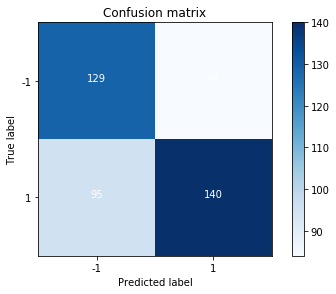

In [99]:
pred_y = rf.predict(tX)  # ***

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, pred_y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['-1','1'], title='Confusion matrix')

plt.show()

In [100]:
# 回测
test_X['pred_y']= rf.predict(tX)
test_X['newp'] = test_X['close']

/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
stpoint = test_X[test_X.date==test_X.date.min()].index.values[0]+1

for ind in range(stpoint,stpoint+len(test_X)-1): 
    if (test_X.pred_y[ind-1] > 0):
        test_X.newp[ind] = test_X.newp[ind-1] * (1+ test_X.vclose[ind])
    else:
        test_X.newp[ind] = test_X.newp[ind-1]

/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/NeiL/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5,1,'sz.399001')

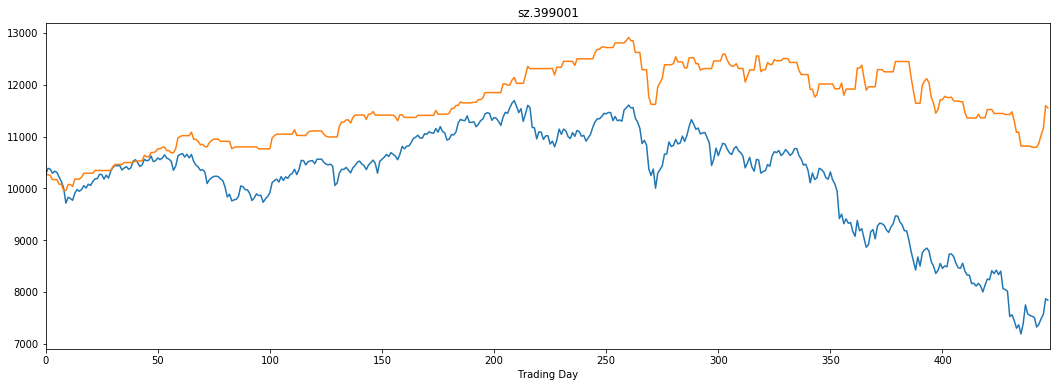

In [43]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'sh.000016')

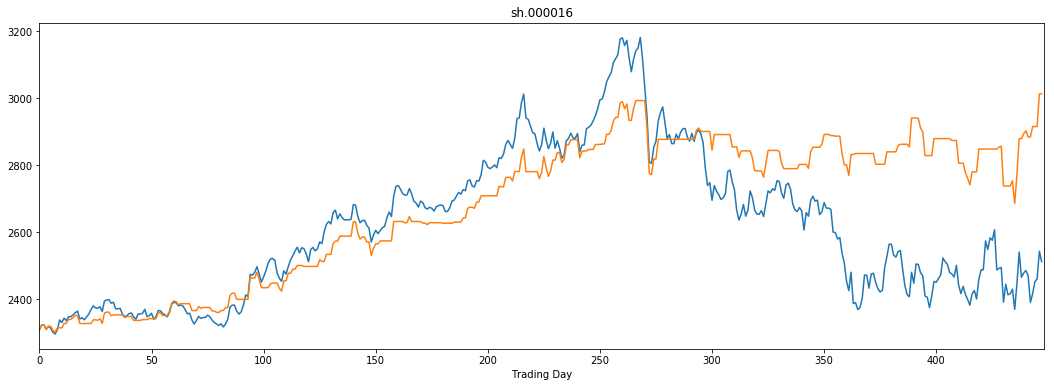

In [91]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'sh.000905')

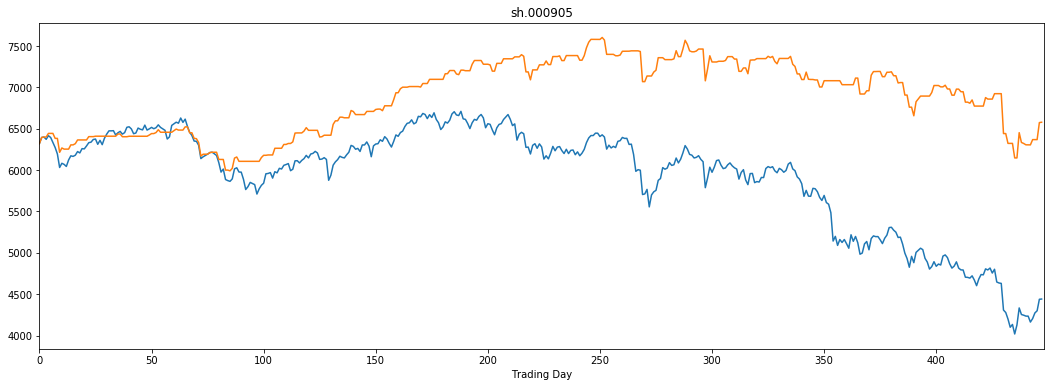

In [59]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'sh.000300')

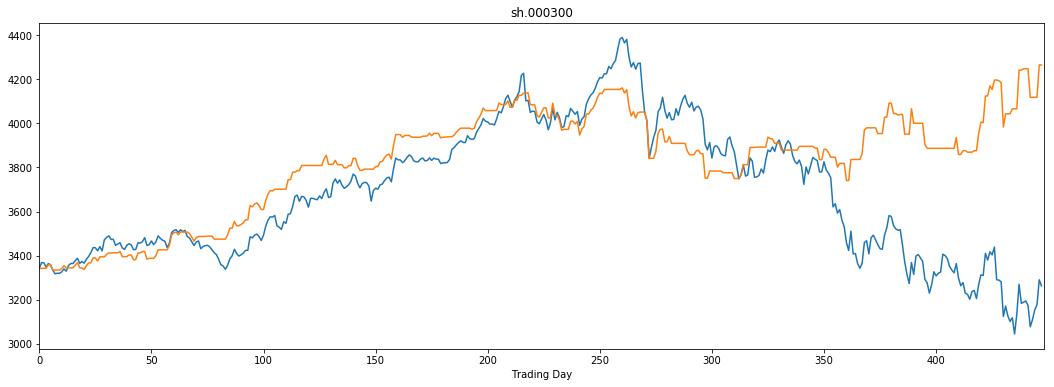

In [102]:
# sh.000300 沪深300
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

#### Train 是 2007年初到2017年底；Test是2018年

In [70]:
ss

['std5',
 'vma20_l2',
 'vstd5_l1',
 'vstd10',
 'dis23_l2',
 'dma20_l2',
 'vma20_l1',
 'std5_l1',
 'vma20',
 'dis23_l1']

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import math

Featurex=[ss[0]]
for col in ss[1:6]:
    Featurex.append(col)
    print(len(Featurex))
    X = train_X[Featurex]
    tX = test_X[Featurex]

    ggg = printrf(X, train_y, tX, test_y, len(Featurex))
    print(ggg)

2
[0.5773195876288659, 0.8957915831663327, 25, 2, 1, 1]
3
[0.5643564356435643, 0.9408163265306122, 15, 2, 2, 4]
4
[0.5555555555555556, 0.988169798190675, 30, 2, 2, 6]
5
[0.5652173913043478, 0.976140350877193, 10, 1, 4, 4]
6
[0.5504587155963303, 0.9422946367956552, 10, 2, 4, 5]


In [72]:
ss.remove('vma20_l2') #gai

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import math

Featurex=[ss[0]]
for col in ss[1:6]:
    Featurex.append(col)
    print(len(Featurex))
    X = train_X[Featurex]
    tX = test_X[Featurex]

    ggg = printrf(X, train_y, tX, test_y, len(Featurex))
    print(ggg)

2
[0.5428571428571428, 0.8692461641094062, 10, 2, 1, 5]
3
[0.6132075471698113, 0.958217270194986, 10, 1, 2, 2]
4
[0.591304347826087, 0.9340136054421768, 20, 3, 1, 6]
5
[0.5789473684210527, 0.9476584022038568, 10, 2, 4, 4]
6
[0.5462962962962963, 0.921715452688904, 10, 2, 1, 3]


In [74]:
Featurex=['std5','vstd5_l1','vstd10']
X = train_X[Featurex]
tX = test_X[Featurex]

rf=RandomForestClassifier(n_estimators=10,
                              min_samples_leaf=1,     
                              max_features=2,
                              max_depth=18,
                              random_state=0) 
rf.fit(X, train_y)
print(metrics.classification_report(train_y, rf.predict(X)))
print(metrics.classification_report(test_y, rf.predict(tX)))
# 较优特征和参数选择
# sz.399001 深证成指 ['vstd5', 'vma20_l2', 'std5'] 5、1、1、None p1 = 0.53
# sh.000905 中证500 ['vclose','vstd5','pp20','vma20_l2','pp10','dis23_l2','dclose','dis23_l1','pp5','vma20'] 10、1、1、None p1 = 0.6
# sh.000016 上证50  ['vma20_l2','D23_l2','vstd20','dstd5','std5'] 25、3、1、21  p1 = 0.62
# sh.000300 沪深300 ['std5','vstd5_l1','vstd10','std5_l1'] 25、2、2、17 p1 = 0.62

             precision    recall  f1-score   support

         -1       0.96      0.95      0.95      1247
          1       0.96      0.96      0.96      1429

avg / total       0.96      0.96      0.96      2676

             precision    recall  f1-score   support

         -1       0.66      0.61      0.64       106
          1       0.61      0.66      0.64        98

avg / total       0.64      0.64      0.64       204



Confusion matrix, without normalization
[[65 41]
 [33 65]]


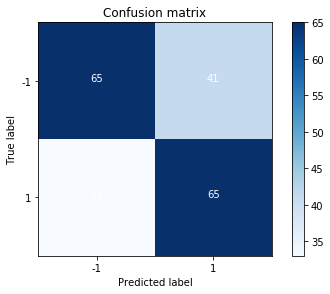

In [75]:
pred_y = rf.predict(tX)  # ***

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, pred_y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['-1','1'], title='Confusion matrix')

plt.show()

In [76]:
# 回测
test_X['pred_y']= rf.predict(tX)
test_X['newp'] = test_X['close']

/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
stpoint = test_X[test_X.date==test_X.date.min()].index.values[0]+1

for ind in range(stpoint,stpoint+len(test_X)-1): 
    if (test_X.pred_y[ind-1] > 0):
        test_X.newp[ind] = test_X.newp[ind-1] * (1+ test_X.vclose[ind])
    else:
        test_X.newp[ind] = test_X.newp[ind-1]

/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/NeiL/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/NeiL/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5,1,'sz.399001')

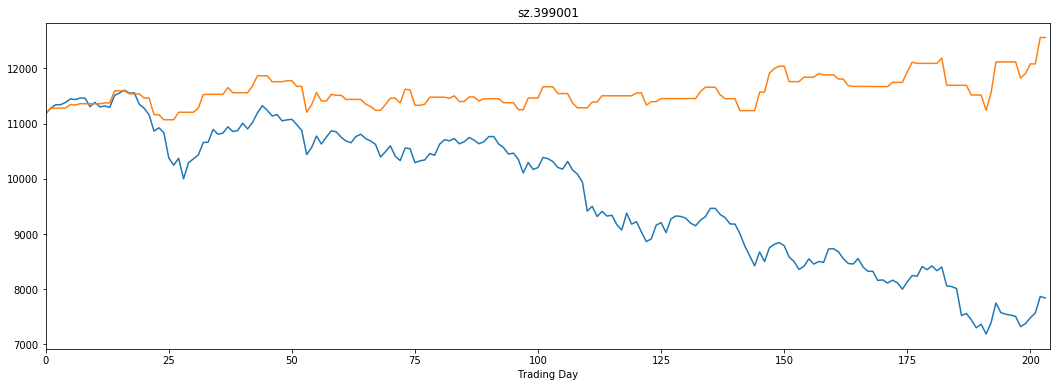

In [62]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'sh.000905')

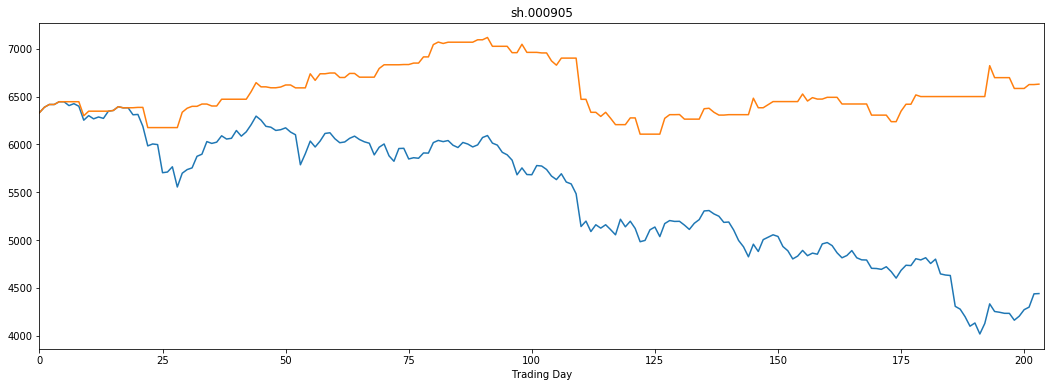

In [126]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'sh.000016')

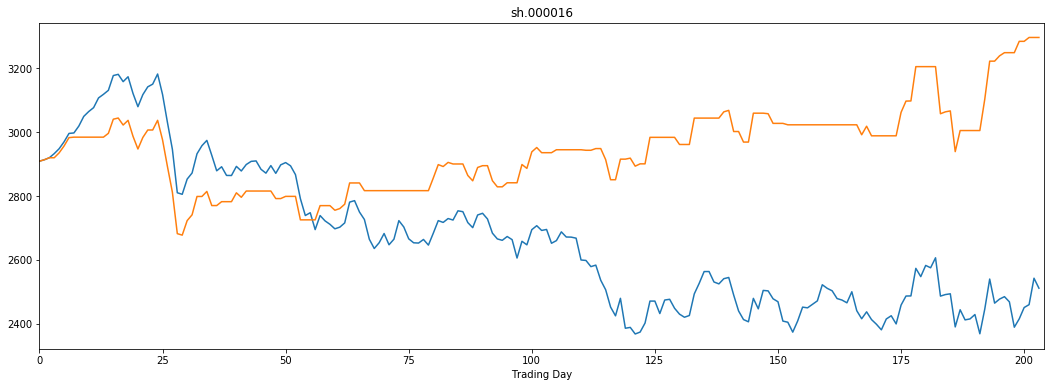

In [91]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'sh.000300')

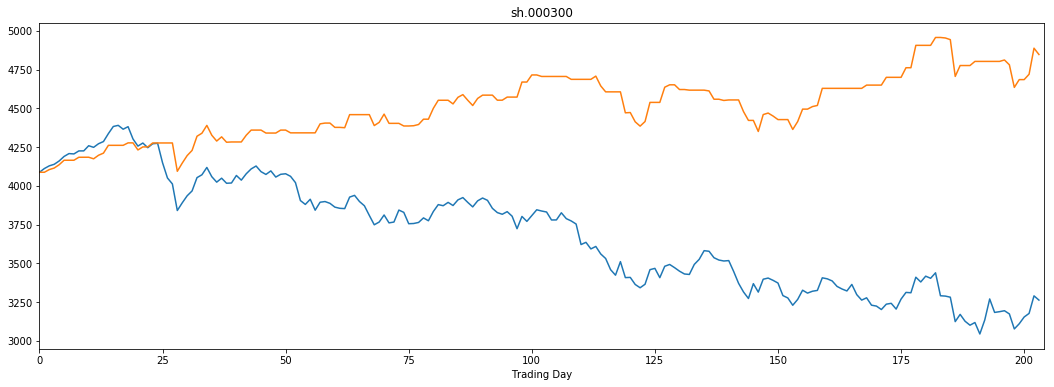

In [78]:
# sh.000300 沪深300
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,test_X.shape[0]),test_X.close)
plt.plot(range(0,test_X.shape[0]),test_X.newp)
plt.xlim(0,test_X.shape[0])
# plt.ylim(test_X.close.min()-50,test_X.close.max()+50)
plt.xlabel('Trading Day')
plt.title(ZSNAME)

Text(0.5,1,'KL ClOSE + MA')

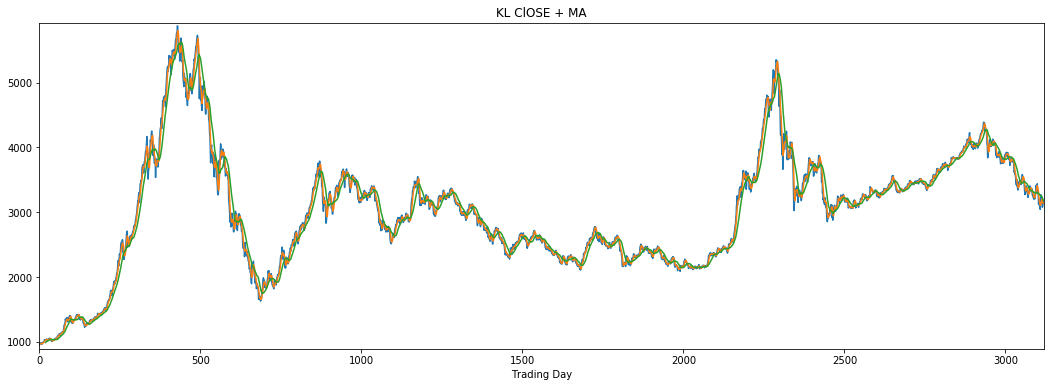

In [64]:
fig = plt.figure(figsize=(18,6))
plt.plot(range(0,KL.shape[0]),KL.close)
plt.plot(range(0,KL.shape[0]),KL.ma5)
# plt.plot(range(0,KL.shape[0]),KL.ma10)
plt.plot(range(0,KL.shape[0]),KL.ma20)
plt.xlim(0,KL.shape[0])
plt.ylim(KL.close.min()-50,KL.close.max()+50)
plt.xlabel('Trading Day')
plt.title('KL ClOSE + MA')